In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_name = "v15_optwpelegamma"
model_dir = "../models/"+model_name
det = "EB"
model_version = 1
numpy_version = 1
limit_files = 10
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/wp_comparison/gammas/numpy_wp_gamma_v{numpy_version}/training/"

In [4]:
files_ele = f"/storage/ECAL/training_data/electrons/numpy_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/gammas/numpy_v{numpy_version}/training/"

In [4]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  5150559
N events gamma:  4981490


Balance gamma and electron

In [5]:
data_EB = data[data.seed_iz == 0]
data_EE = data[data.seed_iz != 0]

In [12]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 27578255
Sample in EE: 9563901
Sample in EB in SC: 1653594
Sample in EE in SC: 675477
N in supercluster:  2329071
N out supercluster:  34813085
14.947197831238292


In [13]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  6112489
Not caloMatch samples:  31029667


# Data Preparation

In [6]:
if det == "EB":
    data = data_EB
if det == "EE":
    data = data_EE

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [7]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  15.643245139915113


# Array preparation

In [28]:
data

,calo_seed_index,cl_etaWidth,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_f5_swissCross,cl_nxtals,cl_phiWidth,cluster_deta,...,seed_f5_swissCross,seed_iz,seed_nxtals,seed_phi,seed_phiWidth,window_index,particle,et_bin,eta_bin,w
1,-1,0.002766,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002089,-0.016367,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
5,2,0.002557,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001303,0.102629,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
6,-1,0.002266,1.647160,0.009259,0.000043,0.008191,0.701537,1,0.001874,-0.158738,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
10,2,0.002434,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001172,0.136999,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
11,1,0.002267,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001510,0.146770,...,0.341402,0,2,-0.967447,0.001695,maaimtxxj,gamma,0,6,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34420905,2,0.002469,1.000000,0.014994,-0.000176,0.014128,0.307549,1,0.008952,-0.184024,...,0.707970,0,1,-0.480436,0.001315,isxkdovpx,electron,0,3,1.000000
34420906,1,0.002529,1.616666,0.018228,0.000150,0.017587,0.663418,1,0.001423,0.001223,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420907,1,0.002505,1.249638,0.008355,-0.000112,0.015185,0.750362,3,0.001400,0.018357,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420909,-1,0.002163,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002124,-0.178211,...,1.000000,0,1,-0.864838,0.002363,lxponyheo,electron,0,4,1.000000


In [8]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_{}.pkl".format(model_version, det), "wb"))

In [18]:
scaler.mean_

array([ 3.37056124e-03, -1.74593130e-05,  5.36130602e-03,  1.23126729e+02,
        2.80265087e+01, -3.78455052e-03, -1.50203344e-04,  2.83484634e+00,
        6.40677925e-01,  1.01554926e+00,  2.75737241e-02, -1.77616711e-05,
        3.32061958e-02,  4.89319494e-01,  6.44707573e+00,  1.50138129e-02,
        1.67344891e-02,  2.79334186e+00,  3.08046911e-02,  6.27775699e-05,
        3.31590078e-02,  2.61119929e-01,  1.71585841e+00,  4.72540581e-03,
        3.88576832e-03])

In [19]:
scaler.scale_

array([2.12589494e+00, 1.81044039e+00, 9.99985628e-01, 1.46820096e+02,
       3.00979511e+01, 1.12098571e-01, 3.27104817e-01, 3.59360965e+00,
       9.23493314e-01, 1.99068714e-01, 1.25832325e-02, 3.53237934e-04,
       1.50224864e-02, 4.04929254e-01, 6.05649518e+00, 8.35942362e-03,
       1.01887911e-02, 1.01619895e+01, 2.27360544e-02, 5.72288469e-04,
       2.39331450e-02, 3.07576377e+00, 2.33820102e+00, 7.15756749e-03,
       8.16390373e-03])

In [10]:
print("N. samples:", X.shape[0])

N. samples: 11895361


In [18]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.10)

### Some plots

In [10]:
# Import all the required Libraries
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [11]:
model_EB = keras.models.load_model(model_dir+"/model_v{}_{}.hd5".format(1,"EB"))
model_EE = keras.models.load_model(model_dir+"/model_v{}_{}.hd5".format(1,"EE"))

# AUC by eta and Et bin

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

data["y"] =  model_EB.predict(scaler.transform(data[cols].values), batch_size=4096)

ets = [0,20,40,60,80,100]
if det=="EB":
    etas = [0, 0.4,0.8, 1.2,1.479]
if det=="EE":
    etas = [1.479,1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)


[-1.  0.  1.  2.  3.  4.  5.]


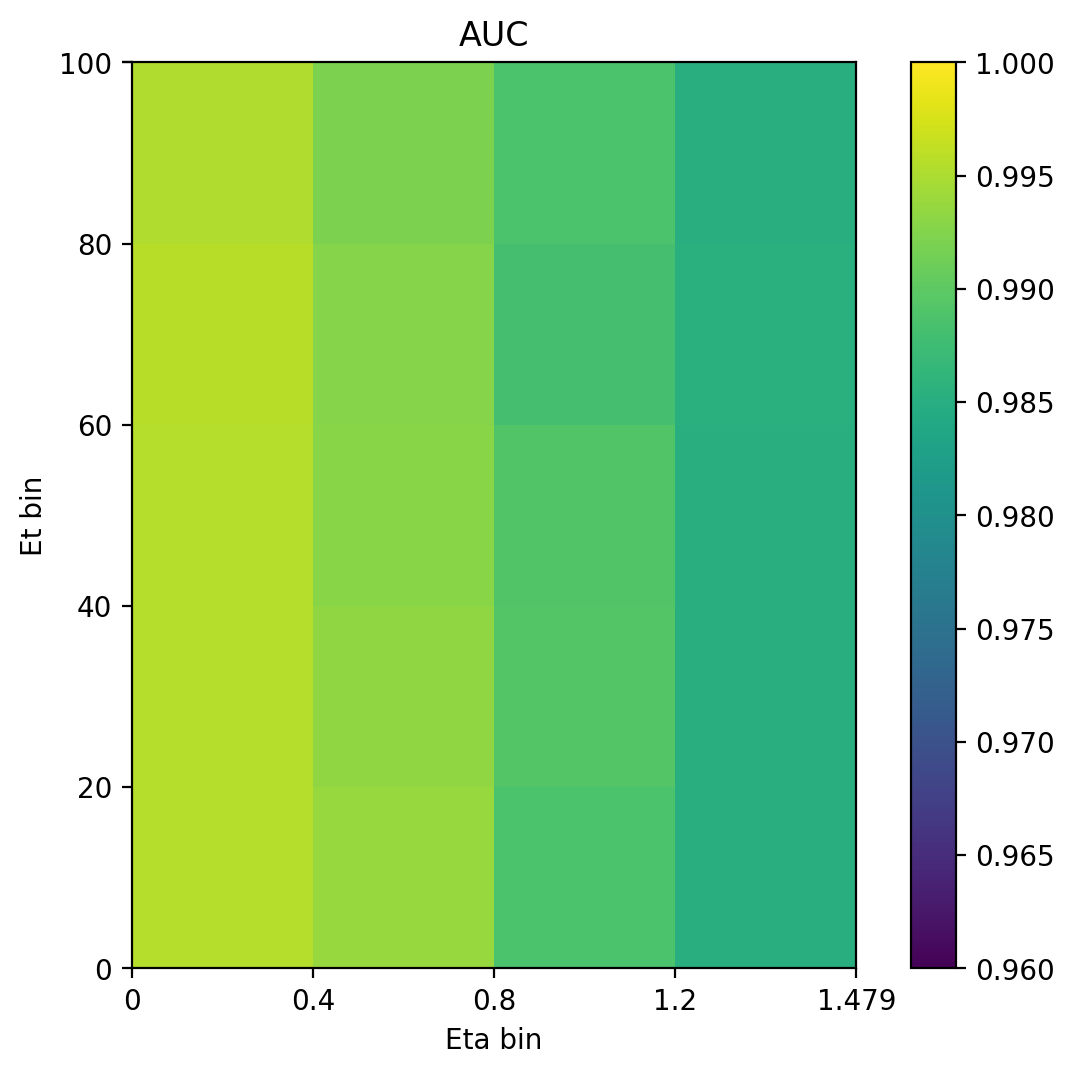

In [13]:
a = result.values.reshape((len(etas)-1,len(ets)-1))
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)

c = ax1.imshow(a.T, vmax=1, vmin=0.96)
ax1.set_xlabel("Eta bin")
ax1.set_ylabel("Et bin")
ax1.set_title("AUC")

locs,labels  = plt.xticks()
locs = np.append(locs, locs[-2]+1)
plt.xticks((locs-0.5)[1::2], etas)


locs,labels  = plt.yticks()
print(locs)
locs = np.append(locs, locs[-2]+1)
plt.yticks((locs-0.5)[1::], ets)

plt.colorbar(c)

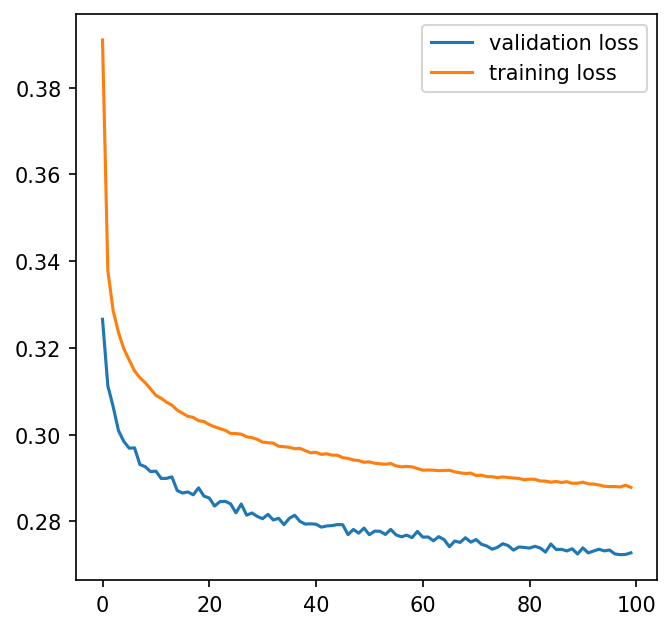

In [23]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

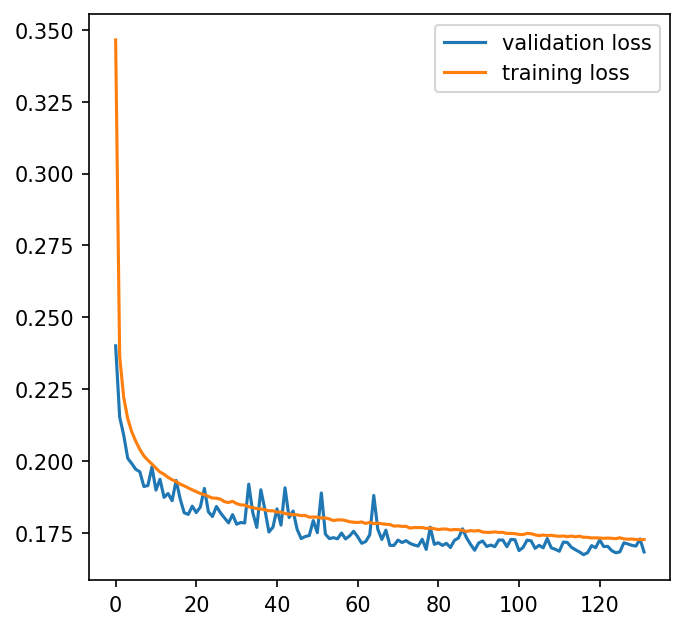

In [26]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

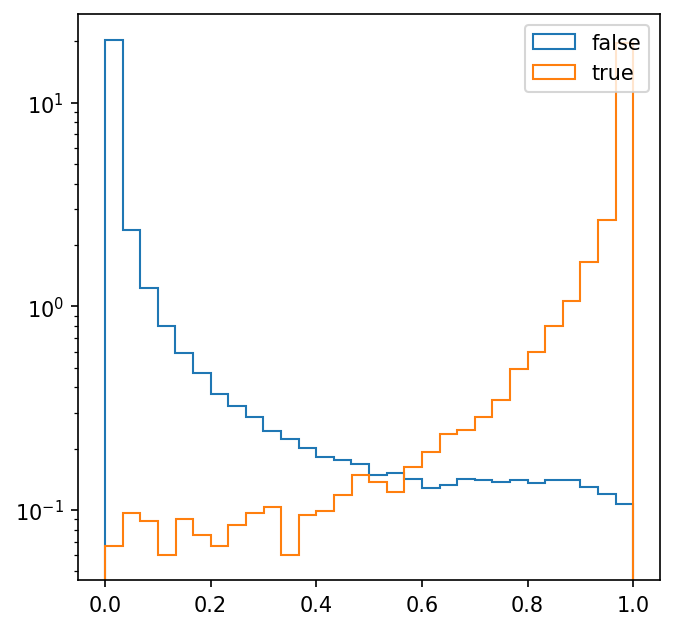

In [24]:
results = model.predict(X_val[:200000])
plt.hist(results[y_val[:200000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:200000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

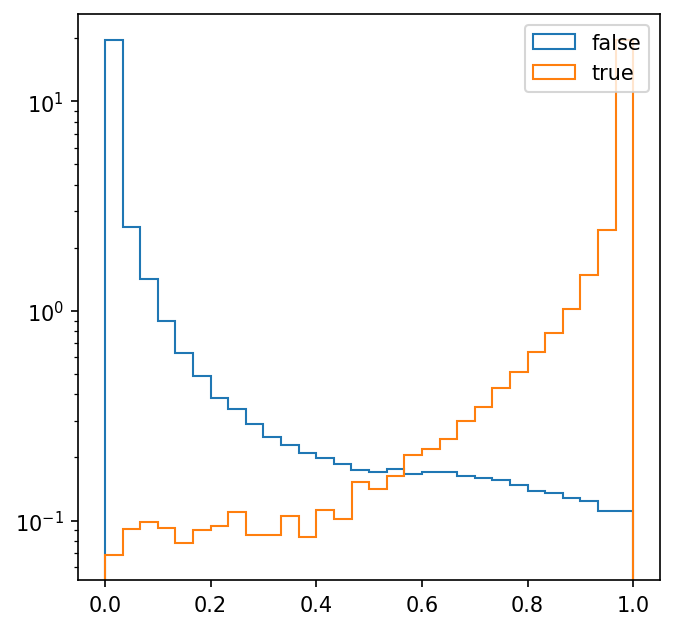

In [28]:
results = model.predict(X_val[:500000])
plt.hist(results[y_val[:500000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:500000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [25]:
plt.savefig(model_dir +"/output_model_v2_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

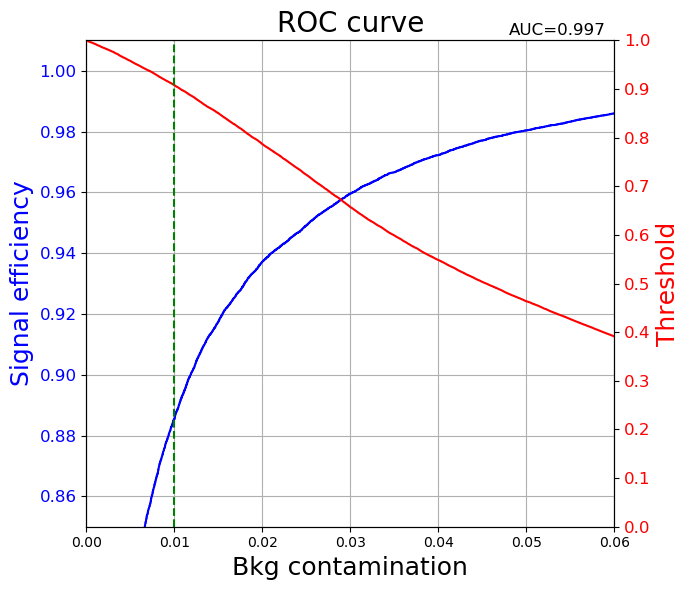

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()